# Code to run simulations.

Look below for instruction

In [1]:
!git clone https://github.com/aglie/seminar_disorder_2025.git

Cloning into 'seminar_disorder_2025'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 53 (delta 22), reused 17 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 2.50 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [5]:
cd seminar_disorder_2025

/content/seminar_disorder_2025


In [6]:
!pip install ase
!pip install gemmi

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from CalculateScattering import CrystalStructure, Grid
from numpy import amax

# ----- Simple Growth Model with Nearest-Neighbor Correlations -----
def generate_correlated_lattice(size, p_same):
    """
    Generate a lattice using a growth model with nearest-neighbor correlations.

    Parameters:
    -----------
    size : tuple
        Size of the 2D grid (height, width)
    p_same : float
        Probability of placing the same atom type as the previous one (0.5 = random, 1.0 = ordered)

    Returns:
    --------
    lattice : numpy.ndarray
        2D array with +1 (Cu) and -1 (Au) values
    """
    # First, create a 1D chain using a Markov process
    height, width = size
    total_sites = height * width

    # Initialize the chain with a random first element
    chain = np.zeros(total_sites, dtype=np.int8)
    chain[0] = 1 if np.random.random() < 0.5 else -1

    # Grow the chain site by site using the transition matrix
    for i in range(1, total_sites):
        prev_type = chain[i-1]
        # Decide whether to place the same or different atom
        if np.random.random() < p_same:
            chain[i] = prev_type  # Same as previous
        else:
            chain[i] = -prev_type  # Different from previous

    # Reshape to 2D
    lattice = chain.reshape(size)
    return lattice

# ----- Visualization -----
def visualize_lattice(lattice):
    """
    Visualize the lattice configuration.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(lattice, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar(ticks=[-1, 1], label='Atom Type (Cu: +1, Au: -1)')
    plt.title("Disordered Solid Configuration")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# ----- Convert Lattice to Crystal Structure -----
def convert_lattice_to_crystal_structure(lattice, a=3.0):
    """
    Convert a 2D lattice of +1 (Cu) and -1 (Au) into a 3D CrystalStructure
    """
    height, width = lattice.shape

    # Create atoms list (element_type, x, y, z)
    atoms = []
    for x in range(height):
        for y in range(width):
            # Convert +1 to Cu, -1 to Au
            element = "Cu" if lattice[x, y] == 1 else "Au"
            atoms.append((element, x, y, 0))

    # Create crystal structure with a simple cubic unit cell
    crystal = CrystalStructure(
        cell_parameters=(a, a, a, 90, 90, 90),  # Simple cubic cell
        atoms=atoms,
        supercell=(width, height, 1)  # 2D structure with thickness of 1
    )

    return crystal

# ----- Calculate Diffuse Scattering -----
def calculate_diffuse_scattering(crystal, lattice_size, blur=0.01):
    """
    Calculate diffuse scattering from a crystal structure

    Returns:
    --------
    tuple: (grid, sf, intensities)
    """
    # Create grid for scattering calculation
    ll = 5  # Lower limit in reciprocal space
    grid = Grid(
        lower_limits=[-ll, -ll, -1],  # q-vector lower limits
        step_sizes=[1/lattice_size[0], 1/lattice_size[1], 1],  # Step size related to supercell size
        no_pixels=[ll*2*lattice_size[0], ll*2*lattice_size[1], 2]  # Number of grid points
    )

    # Calculate scattering
    sf = crystal.calculate_scattering(grid, blur=blur)

    # Get intensities (middle z-layer)
    intensities = sf.get_intensities()[:,:,1]

    # Scale intensities for visualization
    intensities = intensities/amax(intensities)

    return grid, sf, intensities

# Instructions

Before we will be running a Monte Carlo simulation, here is a simpler example. We will generate a crystal with disorder only along one direction. This is easier to do, as this can be done with a simple algorithm following what is called "Markov process".

We will split the generation in two parts. First, we will make a lattice as a simple array of +1 and -1.

Visualizing lattice configuration:


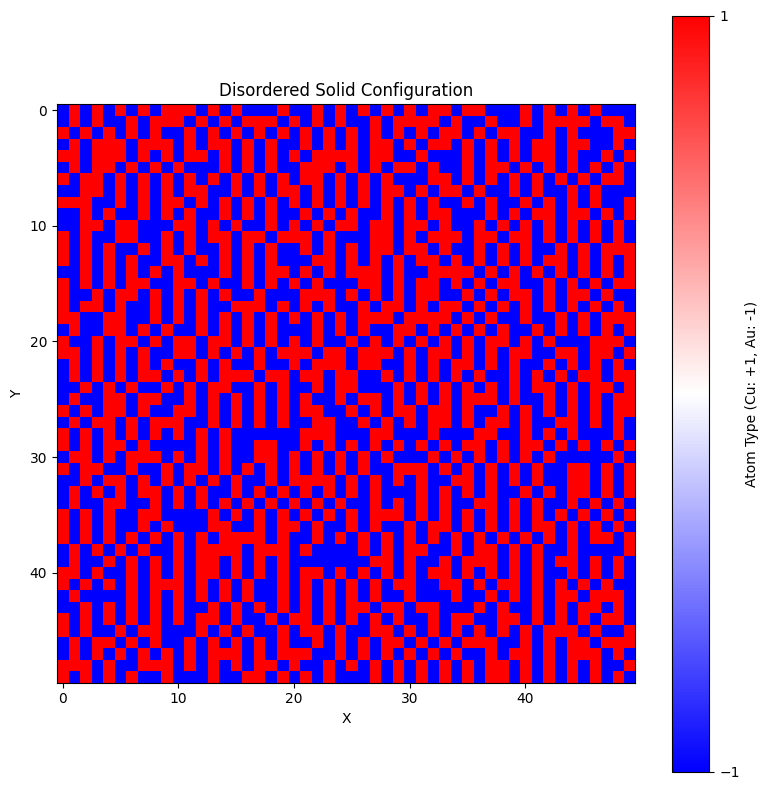

In [8]:
# Define parameters
lattice_size = (50, 50)
correlation_strength = 0.2  # 0.5 = random, 1.0 = perfect correlation, 0 = perfect negative correlation

# Generate correlated lattice
lattice = generate_correlated_lattice(size=lattice_size, p_same=correlation_strength)

# Visualize lattice
print("Visualizing lattice configuration:")
visualize_lattice(lattice)

## Convert lattice to crystal structure

Then let's convert those values to a crystal, which has a particular unit cell dimensions, and consists of Cu and Au atoms

In [9]:
# Convert to crystal structure
crystal = convert_lattice_to_crystal_structure(lattice)

# Save as CIF file
cif_filename = "correlated_structure.cif"
crystal.save_cif(cif_filename)

Structure saved to correlated_structure.cif


In [10]:
from google.colab import files
files.download('correlated_structure.cif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Calculate diffuse scattering

In [ ]:
grid, sf, intensities = calculate_diffuse_scattering(crystal, lattice_size)

# Visualize diffuse scattering
plt.figure(figsize=(8, 6))
plt.imshow(intensities,
           cmap='Greys',
           clim=[0, 0.001],  # Adjust this for better contrast
           origin='lower',
           extent=[grid.lower_limits[0], -grid.lower_limits[0],
                   grid.lower_limits[1], -grid.lower_limits[1]])
plt.colorbar(label='Intensity')
plt.title("Diffuse Scattering")
plt.xlabel("q_x")
plt.ylabel("q_y")
plt.tight_layout()
plt.show()

# Calculate and visualize, zoom in

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(intensities,
           cmap='Greys',
           clim=[0, 0.001],
           origin='lower',
           extent=[grid.lower_limits[0], -grid.lower_limits[0],
                   grid.lower_limits[1], -grid.lower_limits[1]])
plt.title("Diffuse Scattering (Zoomed)")
plt.xlabel("q_x")
plt.ylabel("q_y")
plt.axis([-2.5, 2.5, -2.5, 2.5])  # Zoom in to central region
plt.tight_layout()
plt.show()